# Курсовая работа по теме "Машинное обучение в задачах кредитного скоринга"

In [120]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.model_selection import LearningCurve
import warnings
warnings.filterwarnings('ignore')

### Выбрать набор данных для анализа в соответствии с выбранной темой курсовой работы. Описать этот набор и решаемую задачу.

В данной работе будет использован датасет HMEQ. Набор данных о долевом участии в жилищном строительстве (HMEQ) содержит информацию о параметрах и результатах кредитования по 5 960 недавним кредитам на приобретение жилья. 

Целевой показатель (BAD) - это бинарная переменная, равная 1, если клиент не выполнил обязательства по кредиту или имел серьезные просрочки, и 0 - в случае своевременного погашения. Для каждого заявителя было зарегистрировано 12 входных переменных: LOAN - сумма кредита, MORTDUE - сумма задолженности заемщика по ипотеке, VALUE - оценочная стоимость объекта недвижимости, REASON - цель кредита ('DebtCon' - консолидация долга, 'HomeImp' - улучшение жилищных условий), JOB - род занятий заемщика ('Office' - офисная работа, 'Sales' - работа в продажах, 'Mgr' - управляющая должность, 'ProfExe', 'Self' - самозанятый, 'Other' - другой вариант), YOJ - число лет на текущей работе, DEROG - количество уничижительных замечаний в кредитном отчете заемщика, DELINQ - количество раз, когда заемщик задерживал платеж, CLAGE - срок самой старой кредитной линии в месяцах, NINQ - количество кредитных линий, открытых заемщиком за последние шесть месяцев, CLNO - общее количество кредитных линий, имеющихся у заемщика, DEBTINC - соотношение долга заемщика к доходу, которое рассчитывается путем деления общей суммы ежемесячных платежей заемщика по долгу на его ежемесячный доход.

Задача курсовой работы состоит в том, чтобы автоматизировать процесс принятия решений о выдаче кредита путем создания алгоритма кредитного скоринга, который предсказывает, погасит ли кредит данный заемщик. Для выбора оптимальной модели будут использованы метрики Accuracy score, F1 score, Precision score и Recall score, а также ROC-AUC и PR-AUC.

Загрузим датасет:

In [2]:
df = pd.read_csv('hmeq.csv')

### Провести предварительный анализ и очистку данных. Этот этап включает в себя вывод информации о количественных характеристиках датасета, информацию об отсутствующих значениях, характеристиках и физическом смысле каждого атрибута данных, его значимости для предсказания целевой переменной, вывод нескольких точек данных для иллюстрации структуры данных.

In [3]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
df.shape

(5960, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Заметим, что признаки REASON и JOB являются категориальными, остальные - числовыми.

In [6]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [7]:
df.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

Пропущенные значения в данных могут существенно искажать результаты работы, поэтому пропуски нужно заполнить.\
Для признаков с нечисловыми значениями: заполним пропущенные значения в столбцах REASON и JOB значением 'Other':

In [8]:
df['REASON'].fillna(value='Other', inplace = True)
df['JOB'].fillna(value='Other', inplace = True)

Для признаков DEROG (количество уничижительных замечаний в кредитном отчете заемщика) и DELINQ (количество раз, когда заемщик задерживал платеж) заменим пропуски нулевыми значениями:

In [10]:
df['DEROG'].fillna(value=0, inplace=True)
df['DELINQ'].fillna(value=0, inplace=True)

Для остальных числовых признаков заменим пропуски средним значением по каждому признаку:

In [11]:
df.fillna(value=df.mean(), inplace=True)

In [12]:
df.isna().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

Теперь все пропуски заполнены.

### При необходимости, преобразовать атрибуты исходного датасета в числовые признаки. Этот этап сильно зависит от типа исследуемых данных и может включать в себя векторизацию текста, извлечение признаков их аудио и видео данных, преобразование изображений в плоский численный массив и другие преобразования.

Признаки REASON и JOB имеют тип object, т.е. являются категориальными переменными. Для преобразования этих переменных в числовые используем метод get_dummies() библиотеки pandas. Функция get_dummies() преобразует категориальные переменные, создавая DataFrame со столбцами уникальных переменных и значениями, показывающими наличие или отсутствие этих переменных в наблюдении.

In [13]:
df = df.join(pd.get_dummies(df['REASON'], prefix='REASON', prefix_sep='_'))
df = df.join(pd.get_dummies(df['JOB'], prefix='JOB', prefix_sep='_'))
df.drop(['REASON', 'JOB'], axis=1, inplace=True)

In [14]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,REASON_Other,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.0000,39025.000000,10.500000,0.0,0.0,94.366667,1.000000,9.000000,33.779915,0,1,0,0,0,1,0,0,0
1,1,1300,70053.0000,68400.000000,7.000000,0.0,2.0,121.833333,0.000000,14.000000,33.779915,0,1,0,0,0,1,0,0,0
2,1,1500,13500.0000,16700.000000,4.000000,0.0,0.0,149.466667,1.000000,10.000000,33.779915,0,1,0,0,0,1,0,0,0
3,1,1500,73760.8172,101776.048741,8.922268,0.0,0.0,179.766275,1.186055,21.296096,33.779915,0,0,1,0,0,1,0,0,0
4,0,1700,97800.0000,112000.000000,3.000000,0.0,0.0,93.333333,0.000000,14.000000,33.779915,0,1,0,0,1,0,0,0,0


### Провести описательный анализ данных. Сделать выводы. Этот этап включает в себя определение шкалы измерения каждого признака, выявление аномальных значений, визуализацию распределения каждого признака, при необходимости - проверка на нормальность, построение кореллограмм и совместных распределений каждого признака с целевой переменной, выявление коррелированных признаков и признаков, не несущих информации для данной задачи.

Для начала проверим дисбаланс целевого признака:

In [15]:
df['BAD'].value_counts()

0    4771
1    1189
Name: BAD, dtype: int64

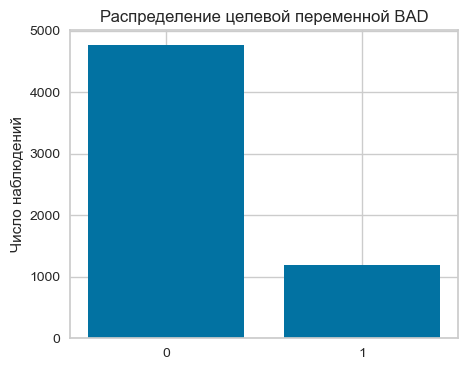

In [16]:
fig = plt.figure(figsize=(5, 4))
plt.bar(['0', '1'], df['BAD'].value_counts())
plt.ylabel('Число наблюдений')
plt.title('Распределение целевой переменной BAD')
plt.show()

Целевой класс несбалансирован: около 80% значений нулевые, оставшиеся 20% равны 1.

Построим ящичковые диаграммы для каждого признака:

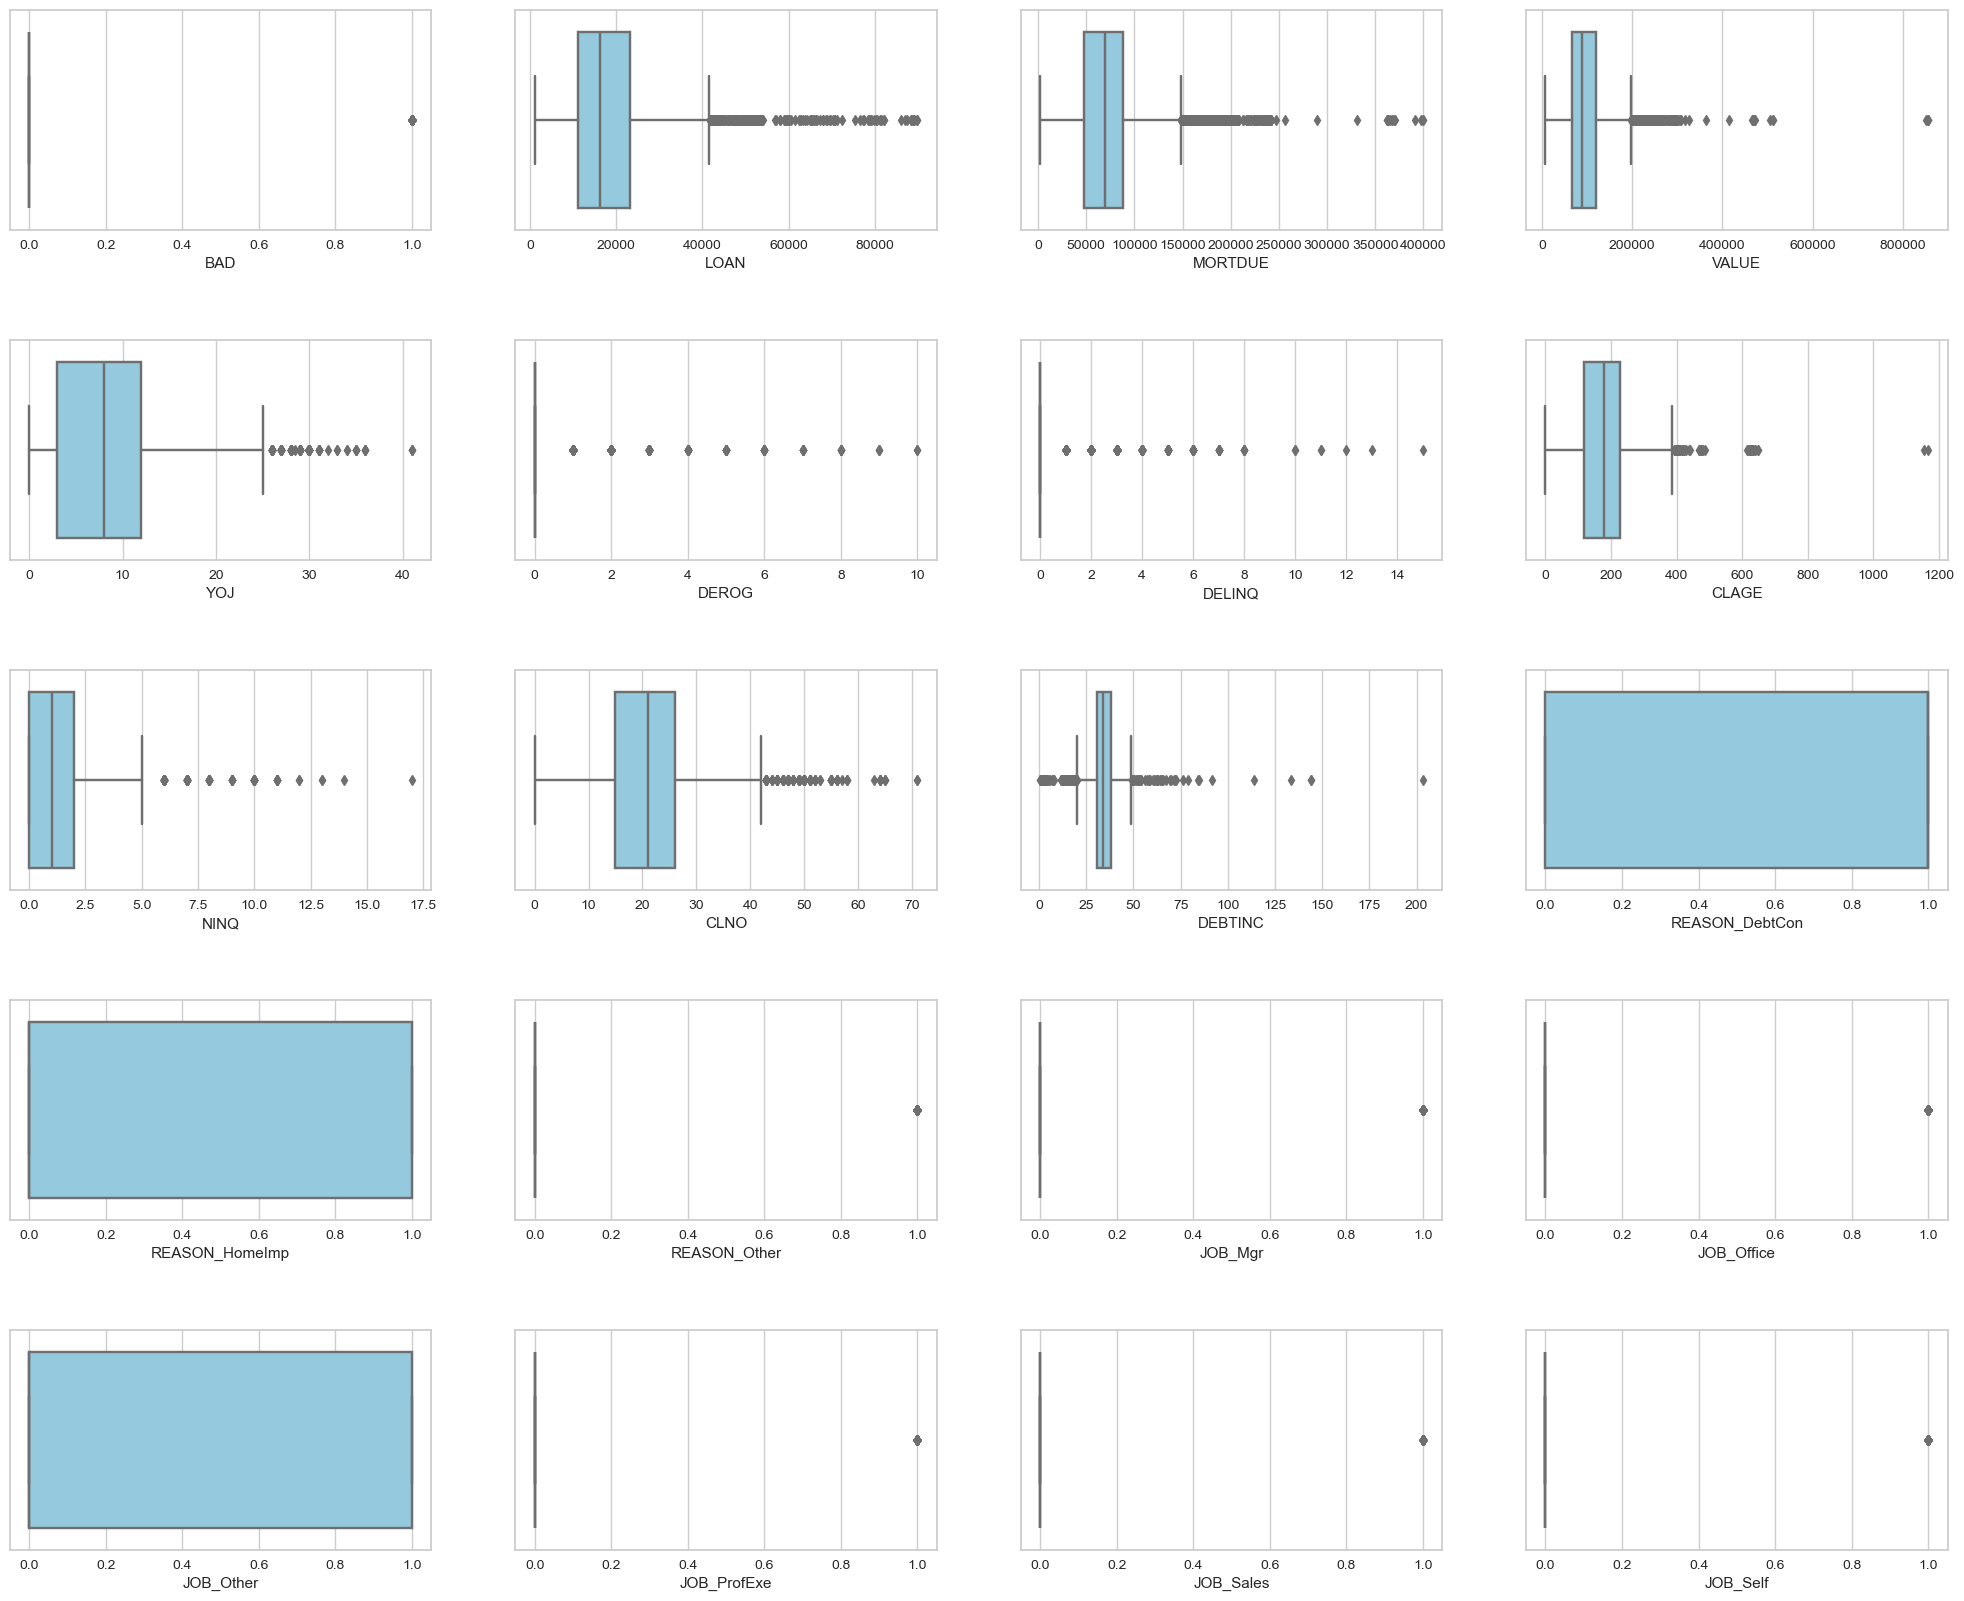

In [17]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for i, ax in zip(df.columns, axes.flat):
    sns.boxplot(data=df, x=i, ax=ax, color='skyblue')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Построим гистограммы распределения для каждого признака:

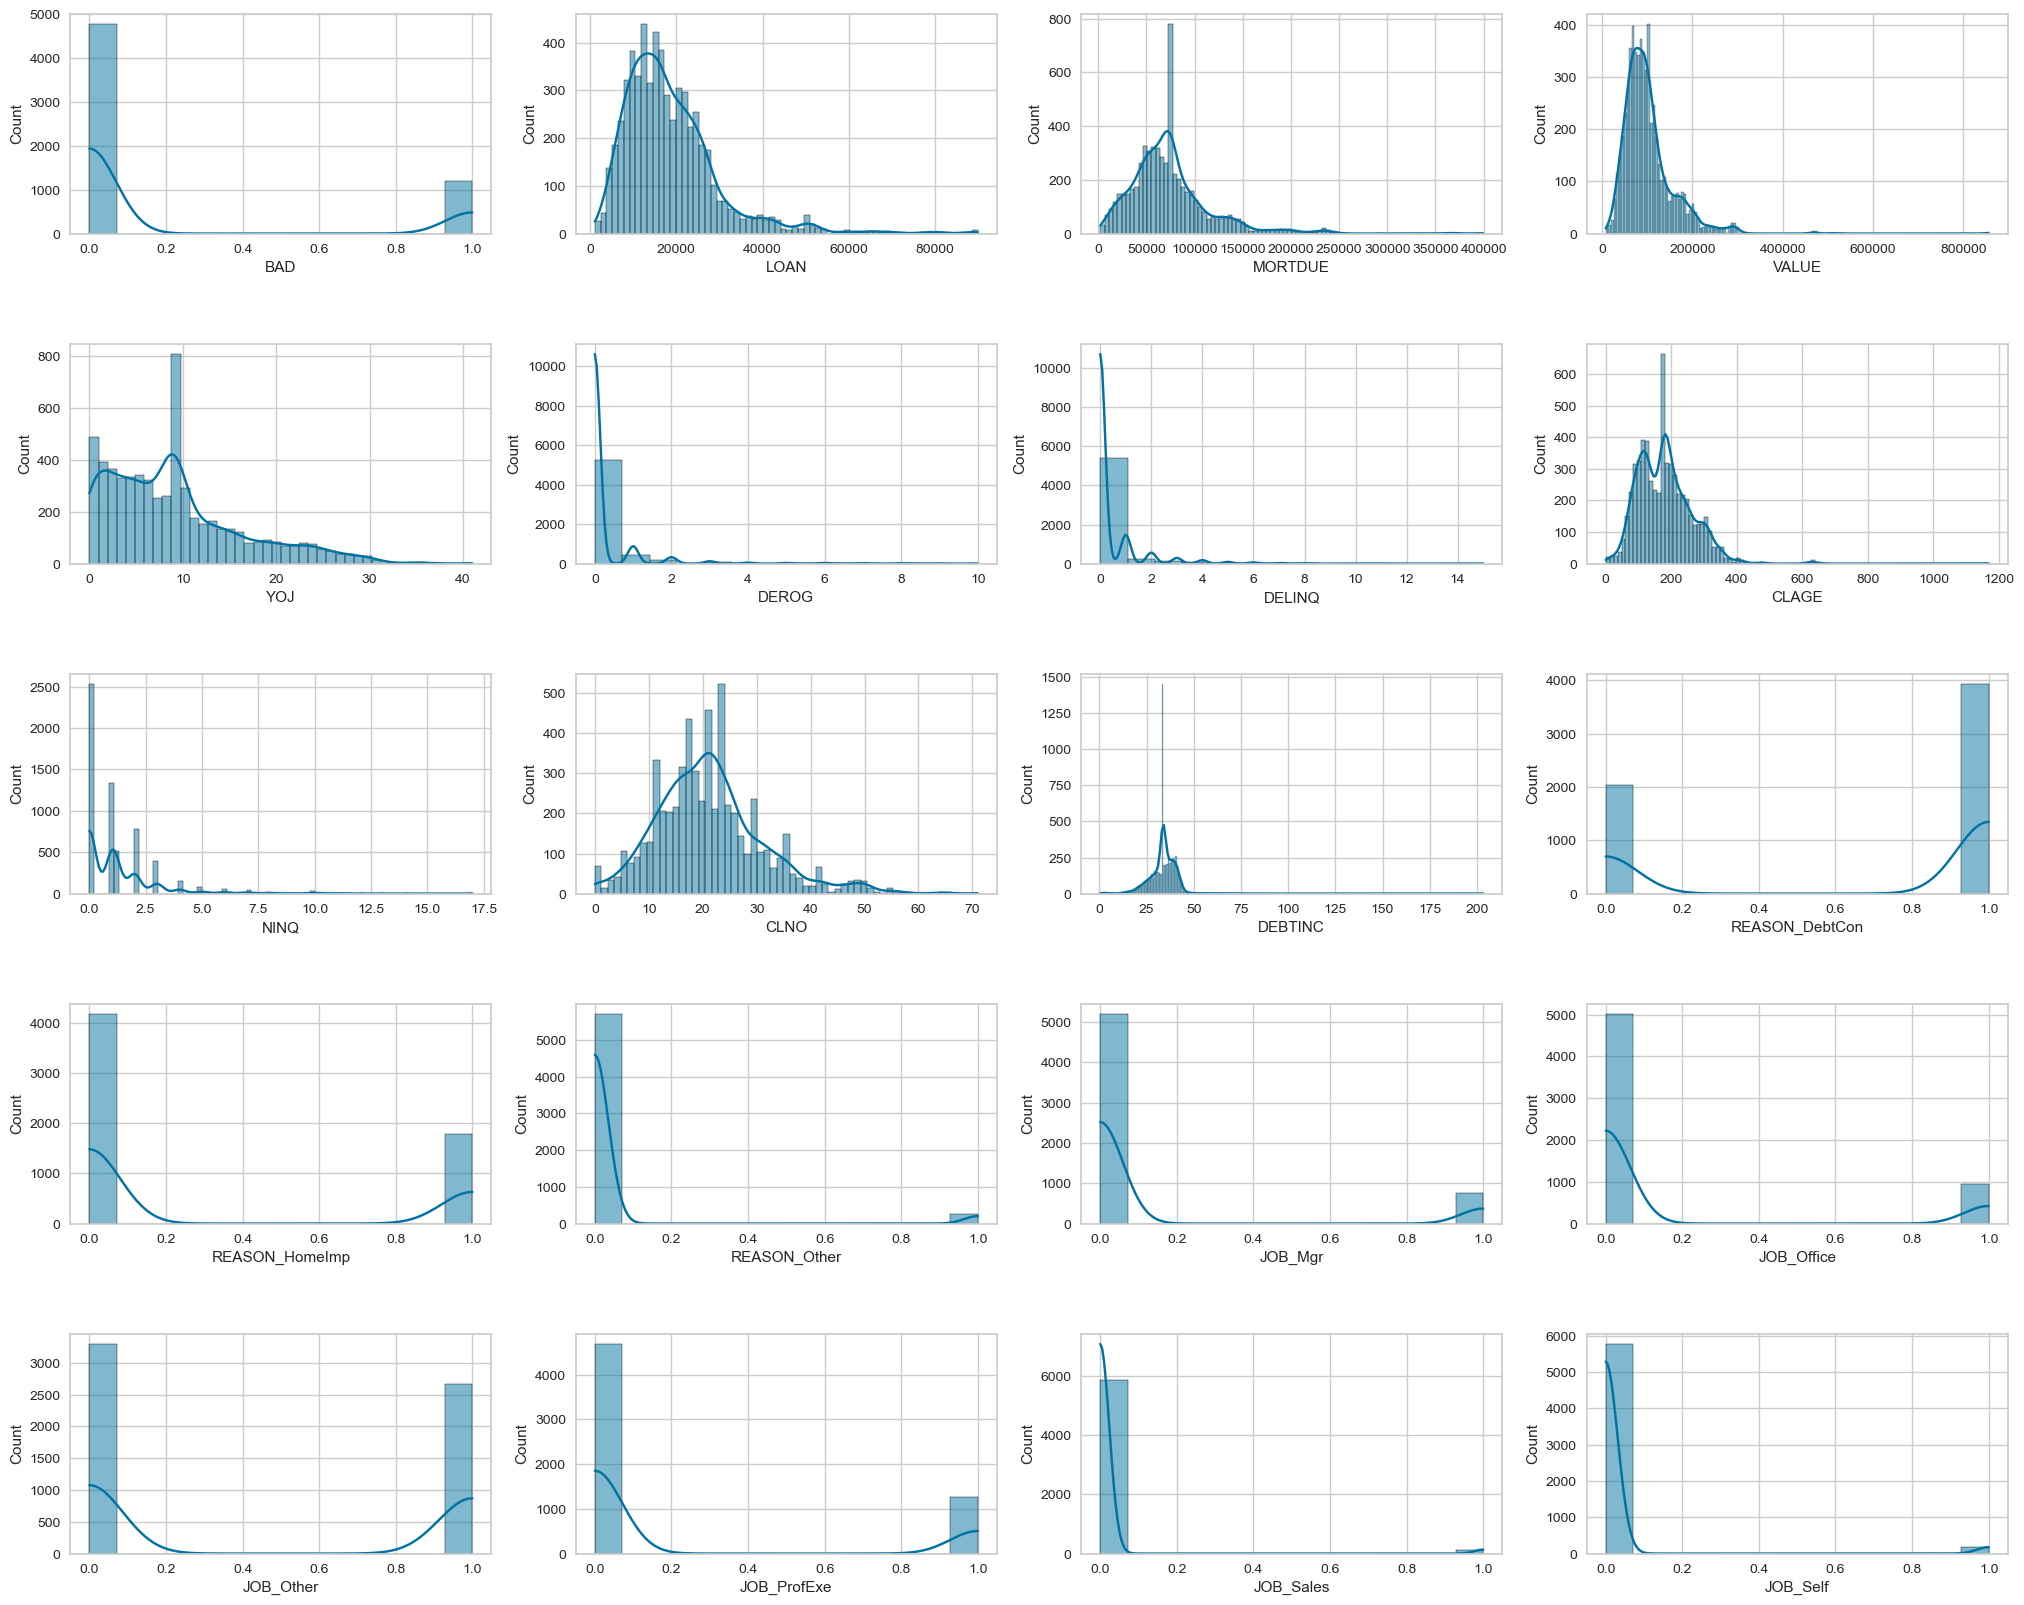

In [18]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for i, ax in zip(df.columns, axes.flat):
    sns.histplot(data=df, x=i, ax=ax, kde=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Попробуем избавиться от выбросов методом IQR:

In [19]:
def remove_outliers(dataframe):
    Q1 = dataframe.quantile(0.25)
    Q3 = dataframe.quantile(0.75)
    IQR = Q3 - Q1
    res = dataframe[~((dataframe < (Q1 - 1.5*IQR)) | (dataframe > (Q3 + 1.5*IQR))).any(axis=1)]
    return res

df0 = remove_outliers(df)
print(f'Число удаленных выбросов: {df.shape[0] - df0.shape[0]}')

Число удаленных выбросов: 4724


Число удаленных наблюдений слишком велико. Это существенно снизит качество данных и прогнозную способность будущих моделей, поэтому метод IQR для удаления аномальных значений в данном случае не подходит.

Построим таблицу коэффициентов корреляции Пирсона:

In [20]:
df.corr()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,REASON_Other,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
BAD,1.000000,-0.075099,-0.046034,-0.028852,-0.058314,0.269921,0.346503,-0.165113,0.168851,-0.004067,0.124324,-0.034210,0.037517,-0.004743,0.032583,-0.073613,0.037949,-0.043561,0.050934,0.046245
LOAN,-0.075099,1.000000,0.216100,0.331862,0.100664,0.006996,-0.028869,0.086874,0.043160,0.071804,0.074823,0.166867,-0.151477,-0.048563,0.018769,-0.018060,-0.058067,0.017488,-0.044993,0.158452
MORTDUE,-0.046034,0.216100,1.000000,0.779787,-0.082856,-0.046476,0.000542,0.130757,0.029480,0.305288,0.128326,0.030416,-0.022894,-0.019581,0.074394,-0.066866,-0.256653,0.256801,0.024822,0.104493
VALUE,-0.028852,0.331862,0.779787,1.000000,0.007382,-0.040727,-0.003615,0.167938,-0.004216,0.264037,0.115796,0.009560,-0.001138,-0.019932,0.045244,-0.058004,-0.264922,0.265850,0.015878,0.150355
YOJ,-0.058314,0.100664,-0.082856,0.007382,1.000000,-0.056245,0.046648,0.190937,-0.067898,0.024023,-0.047642,-0.051937,0.045796,0.018188,0.020148,-0.033088,0.046324,-0.012079,-0.036311,-0.044400
DEROG,0.269921,0.006996,-0.046476,-0.040727,-0.056245,1.000000,0.171286,-0.080144,0.146700,0.050727,0.010744,0.003917,-0.008406,0.009889,0.031342,-0.049223,0.034537,-0.033939,0.030659,0.000836
DELINQ,0.346503,-0.028869,0.000542,-0.003615,0.046648,0.171286,1.000000,0.024874,0.057212,0.159378,0.035353,-0.009383,0.004024,0.012951,0.059350,0.005268,-0.044718,-0.002911,-0.016502,0.021694
CLAGE,-0.165113,0.086874,0.130757,0.167938,0.190937,-0.080144,0.024874,1.000000,-0.110091,0.231595,-0.038052,-0.066849,0.049614,0.044632,-0.023663,-0.001427,-0.076962,0.110431,0.025382,-0.011213
NINQ,0.168851,0.043160,0.029480,-0.004216,-0.067898,0.146700,0.057212,-0.110091,1.000000,0.085148,0.109212,0.121338,-0.115992,-0.022020,0.069826,-0.063735,0.054470,-0.061553,-0.035677,0.016229
CLNO,-0.004067,0.071804,0.305288,0.264037,0.024023,0.050727,0.159378,0.231595,0.085148,1.000000,0.157885,0.116813,-0.107224,-0.031302,0.060210,-0.004549,-0.197815,0.165109,0.049185,0.031325


### Разделить набор данных на обучающую и тестовую выборки. Обосновать количественные характеристики и метод разделения (временной, случайный, последовательный).

In [21]:
X = df.drop(columns=['BAD'])
y = df['BAD']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Для борьбы с дисбалансом целевой переменной сгенерируем синтетические данные. Для этого нам понадобится метод SMOTE() библиотеки imblearn, который анализирует ближайших соседей меньшего класса и генерирует синтетические наблюдения, пока баланс не будет достигнут:

In [23]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

### Обучить несколько моделей для решения выбранной задачи (для задач классификации - не менее 7 различных алгоритмов). Проанализировать результаты, сделать выводы.

#### Логистическая регрессия

In [24]:
%%time
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

CPU times: total: 203 ms
Wall time: 93.4 ms


LogisticRegression()

In [25]:
y_pred_lr = logistic_regression.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)

print(f'Accuracy score: {acc_lr}')
print(f'F1 score: {f1_lr}')
print(f'Precision score: {prec_lr}')
print(f'Recall score: {rec_lr}')

Accuracy score: 0.6325503355704698
F1 score: 0.39502762430939226
Precision score: 0.2837301587301587
Recall score: 0.65


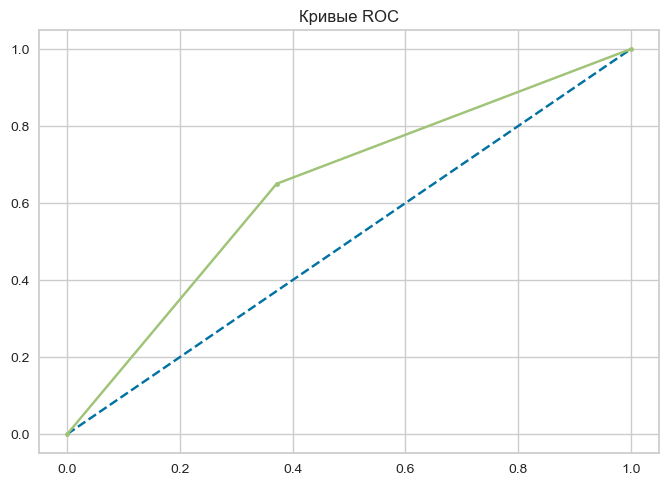

In [26]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_lr)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [27]:
# площадь под кривыми ROC-AUC
roc_lr = sklearn.metrics.roc_auc_score(y_test, y_pred_lr); roc_lr

0.6393004115226337

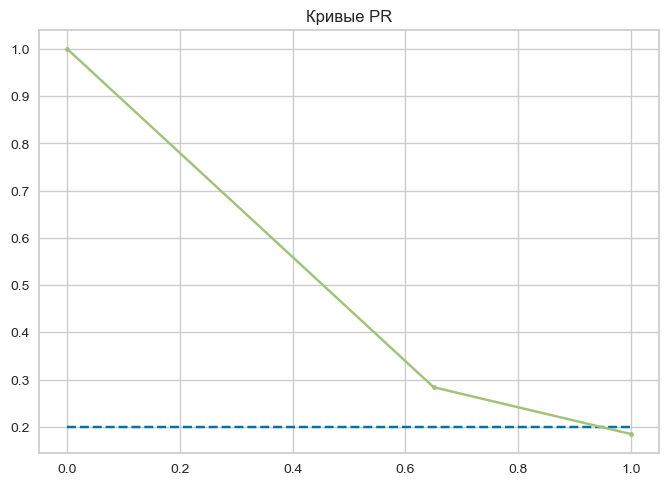

In [28]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_lr)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [29]:
# площадь под кривыми PR-AUC
pr_lr = sklearn.metrics.auc(recall, precision); pr_lr

0.4991637370832001

#### Метод K-ближайших соседей

In [30]:
%%time
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 5.99 ms


KNeighborsClassifier(n_neighbors=3)

In [31]:
y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy score: {acc_knn}')
print(f'F1 score: {f1_knn}')
print(f'Precision score: {prec_knn}')
print(f'Recall score: {rec_knn}')

Accuracy score: 0.738255033557047
F1 score: 0.4545454545454546
Precision score: 0.3693181818181818
Recall score: 0.5909090909090909


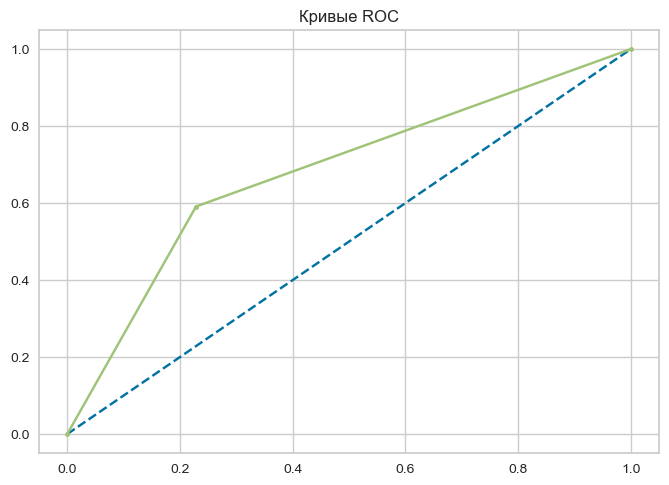

In [32]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_knn)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [33]:
# площадь под кривыми ROC-AUC
roc_knn = sklearn.metrics.roc_auc_score(y_test, y_pred_knn); roc_knn

0.6812570145903478

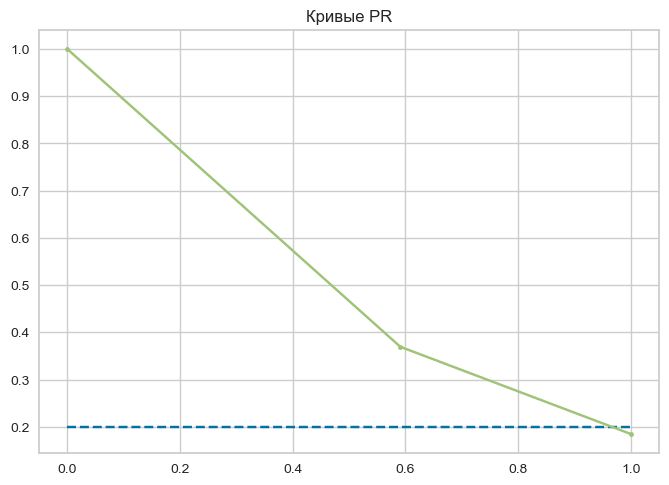

In [34]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_knn)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [35]:
# площадь под кривыми PR-AUC
pr_knn = sklearn.metrics.auc(recall, precision); pr_knn

0.5178653142159854

#### Метод опорных векторов

##### a) с линейным ядром

In [36]:
%%time
svm_lin = SVC(kernel='linear')
svm_lin.fit(X_train, y_train)

CPU times: total: 34min 57s
Wall time: 35min 17s


SVC(kernel='linear')

In [37]:
y_pred_lin = svm_lin.predict(X_test)

acc_lin = accuracy_score(y_test, y_pred_lin)
f1_lin = f1_score(y_test, y_pred_lin)
prec_lin = precision_score(y_test, y_pred_lin)
rec_lin = recall_score(y_test, y_pred_lin)

print(f'Accuracy score: {acc_lin}')
print(f'F1 score: {f1_lin}')
print(f'Precision score: {prec_lin}')
print(f'Recall score: {rec_lin}')

Accuracy score: 0.6946308724832215
F1 score: 0.4203821656050955
Precision score: 0.3235294117647059
Recall score: 0.6


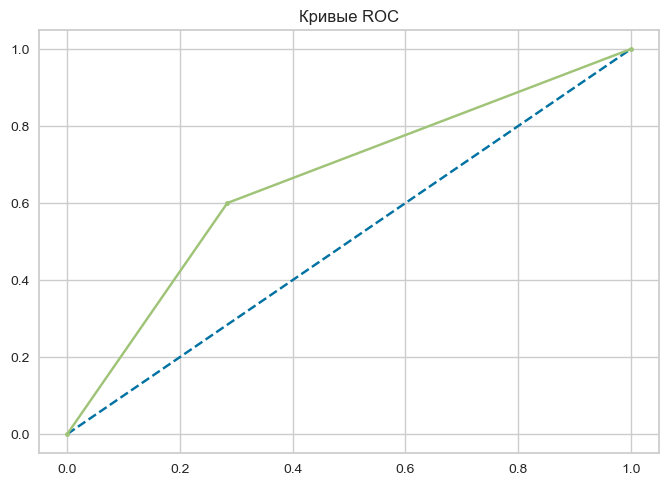

In [38]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_lin)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [39]:
# площади под кривыми ROC - AUC
roc_lin = sklearn.metrics.roc_auc_score(y_test, y_pred_lin); roc_lin

0.6580246913580248

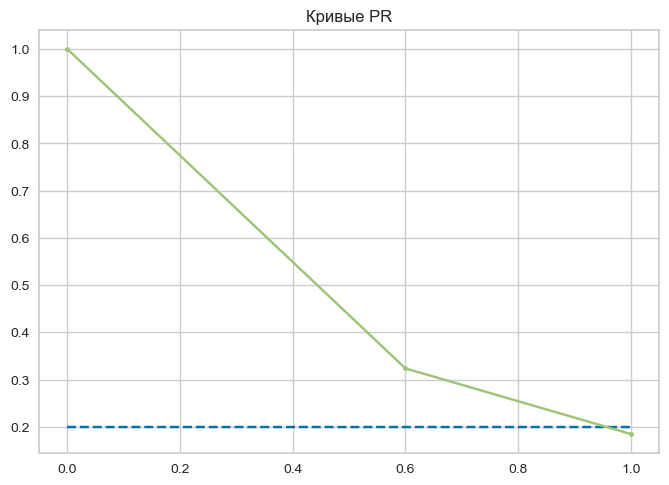

In [40]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_lin)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [41]:
# площадь под кривыми PR-AUC
pr_lin = sklearn.metrics.auc(recall, precision); pr_lin

0.4986774575602053

##### b) с ядром радиальной базисной функции

In [42]:
%%time
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

CPU times: total: 4.84 s
Wall time: 4.85 s


SVC()

In [43]:
y_pred_rbf = svm_rbf.predict(X_test)

acc_rbf = accuracy_score(y_test, y_pred_rbf)
f1_rbf = f1_score(y_test, y_pred_rbf)
prec_rbf = precision_score(y_test, y_pred_rbf)
rec_rbf = recall_score(y_test, y_pred_rbf)

print(f'Accuracy score: {acc_rbf}')
print(f'F1 score: {f1_rbf}')
print(f'Precision score: {prec_rbf}')
print(f'Recall score: {rec_rbf}')

Accuracy score: 0.7273489932885906
F1 score: 0.30997876857749473
Precision score: 0.2908366533864542
Recall score: 0.33181818181818185


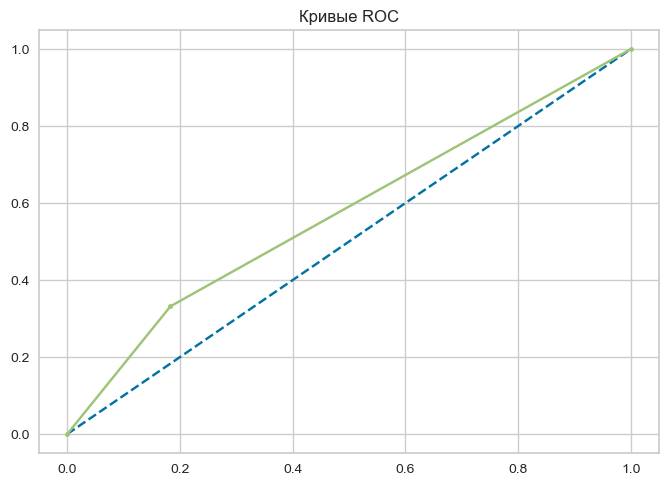

In [44]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_rbf)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [45]:
# площадь под кривыми ROC-AUC
roc_rbf = sklearn.metrics.roc_auc_score(y_test, y_pred_rbf); roc_rbf

0.5743453049008604

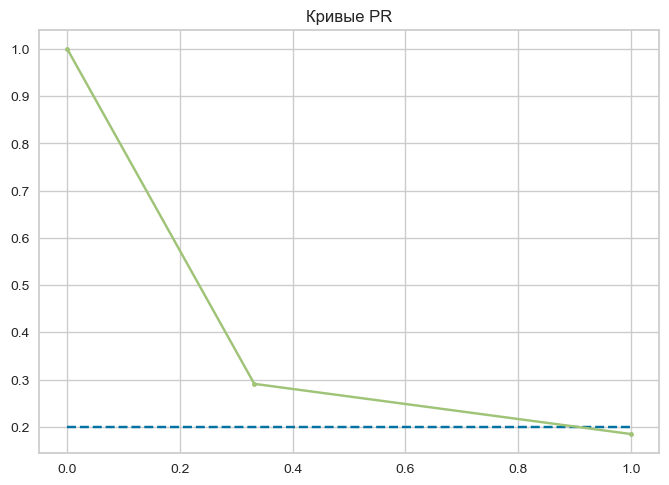

In [46]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_rbf)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [47]:
# площадь под кривыми PR-AUC
pr_rbf = sklearn.metrics.auc(recall, precision); pr_rbf

0.3729884914278214

##### c) с полиномиальным ядром

In [48]:
%%time
svm_poly = SVC(kernel='poly')
svm_poly.fit(X_train, y_train)

CPU times: total: 5.64 s
Wall time: 5.64 s


SVC(kernel='poly')

In [49]:
y_pred_poly = svm_poly.predict(X_test)

acc_poly = accuracy_score(y_test, y_pred_poly)
f1_poly = f1_score(y_test, y_pred_poly)
prec_poly = precision_score(y_test, y_pred_poly)
rec_poly = recall_score(y_test, y_pred_poly)

print(f'Accuracy score: {acc_poly}')
print(f'F1 score: {f1_poly}')
print(f'Precision score: {prec_poly}')
print(f'Recall score: {rec_poly}')

Accuracy score: 0.22399328859060402
F1 score: 0.3143068939955523
Precision score: 0.18777679362267494
Recall score: 0.9636363636363636


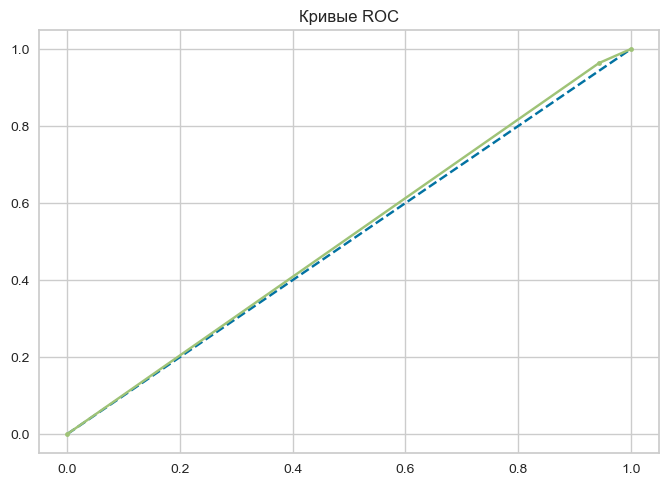

In [50]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_poly)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [51]:
# площадь под кривыми ROC-AUC
roc_poly = sklearn.metrics.roc_auc_score(y_test, y_pred_poly); roc_poly

0.5101103628881407

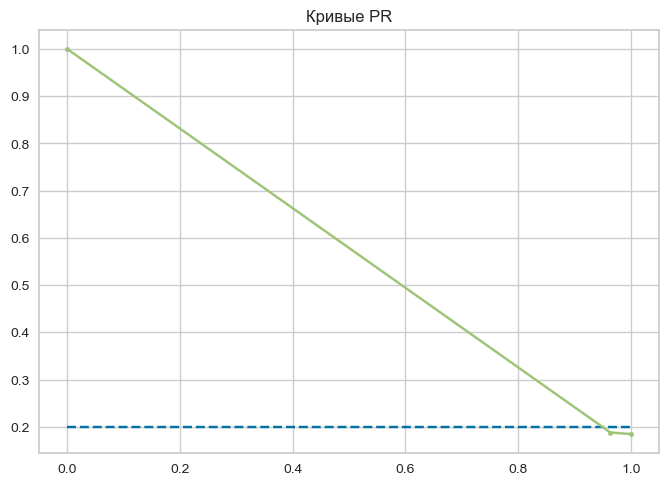

In [52]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_poly)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [53]:
# площадь под кривыми PR-AUC
pr_poly = sklearn.metrics.auc(recall, precision); pr_poly

0.5790622833275059

##### d) с сигмоидным ядром

In [54]:
%%time
svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid.fit(X_train, y_train)

CPU times: total: 2.97 s
Wall time: 2.96 s


SVC(kernel='sigmoid')

In [55]:
y_pred_sigmoid = svm_sigmoid.predict(X_test)

acc_sigmoid = accuracy_score(y_test, y_pred_sigmoid)
f1_sigmoid = f1_score(y_test, y_pred_sigmoid)
prec_sigmoid = precision_score(y_test, y_pred_sigmoid)
rec_sigmoid = recall_score(y_test, y_pred_sigmoid)

print(f'Accuracy score: {acc_sigmoid}')
print(f'F1 score: {f1_sigmoid}')
print(f'Precision score: {prec_sigmoid}')
print(f'Recall score: {rec_sigmoid}')

Accuracy score: 0.4941275167785235
F1 score: 0.2795698924731183
Precision score: 0.18962722852512157
Recall score: 0.5318181818181819


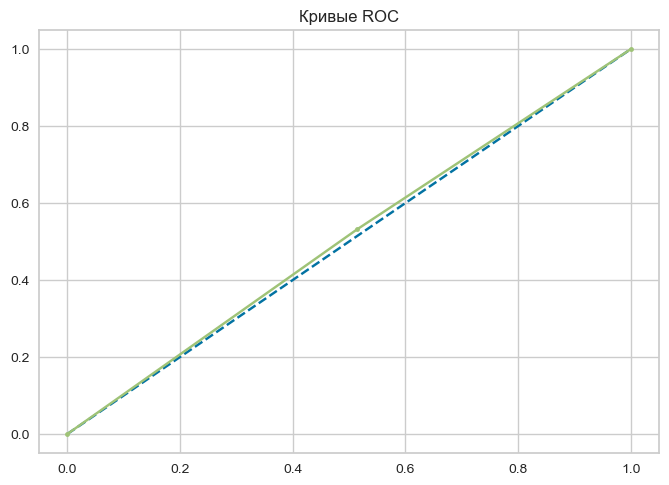

In [56]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_sigmoid)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [57]:
# площадь под кривыми ROC-AUC
roc_sigmoid = sklearn.metrics.roc_auc_score(y_test, y_pred_sigmoid); roc_sigmoid

0.5087074448185559

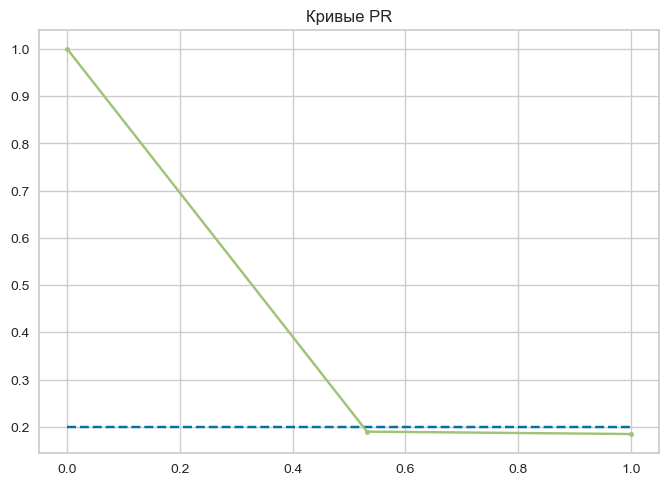

In [58]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_sigmoid)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [59]:
# площадь под кривыми PR-AUC
pr_sigmoid = sklearn.metrics.auc(recall, precision); pr_sigmoid

0.40392740315822884

#### Наивный Байесовский классификатор

In [60]:
%%time
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 7.02 ms


GaussianNB()

In [61]:
y_pred_nb = gaussian_nb.predict(X_test)

acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)
prec_nb = precision_score(y_test, y_pred_nb)
rec_nb = recall_score(y_test, y_pred_nb)

print(f'Accuracy score: {acc_nb}')
print(f'F1 score: {f1_nb}')
print(f'Precision score: {prec_nb}')
print(f'Recall score: {rec_nb}')

Accuracy score: 0.7692953020134228
F1 score: 0.40604751619870405
Precision score: 0.3868312757201646
Recall score: 0.42727272727272725


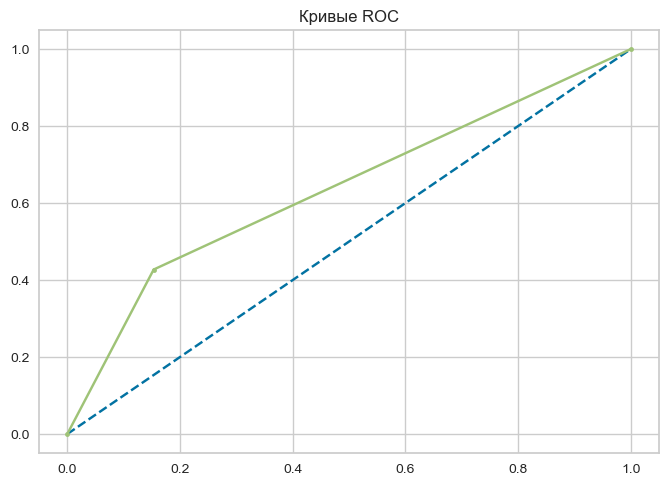

In [62]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_nb)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [63]:
# площадь под кривыми ROC-AUC
roc_nb = sklearn.metrics.roc_auc_score(y_test, y_pred_nb); roc_nb

0.6369902731013842

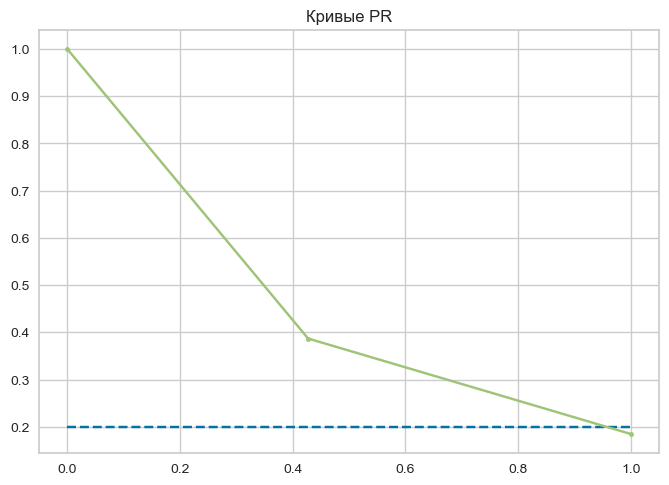

In [64]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_nb)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [65]:
# площадь под кривыми PR-AUC
pr_nb = sklearn.metrics.auc(recall, precision); pr_nb

0.45990435048973455

#### Дерево решений

In [66]:
%%time
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)

CPU times: total: 78.1 ms
Wall time: 83.1 ms


DecisionTreeClassifier()

In [67]:
y_pred_clftree = clf_tree.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_clftree)
f1_dt = f1_score(y_test, y_pred_clftree)
prec_dt = precision_score(y_test, y_pred_clftree)
rec_dt = recall_score(y_test, y_pred_clftree)

print(f'Accuracy score: {acc_dt}')
print(f'F1 score: {f1_dt}')
print(f'Precision score: {prec_dt}')
print(f'Recall score: {rec_dt}')

Accuracy score: 0.889261744966443
F1 score: 0.7
Precision score: 0.7
Recall score: 0.7


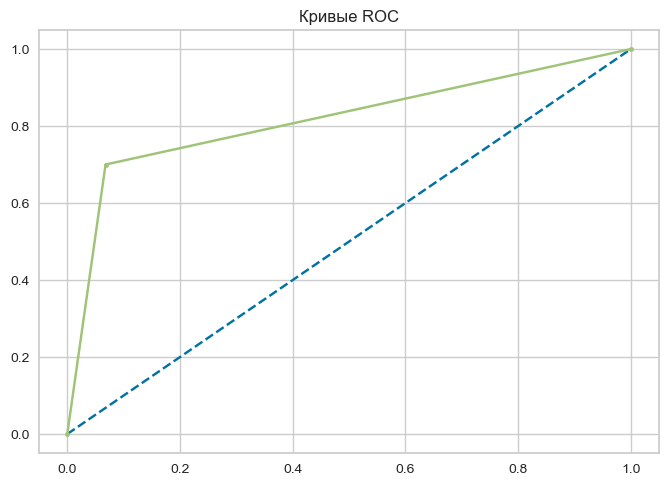

In [68]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_clftree)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [69]:
# площадь под кривыми ROC-AUC
roc_dt = sklearn.metrics.roc_auc_score(y_test, y_pred_clftree); roc_dt

0.8160493827160494

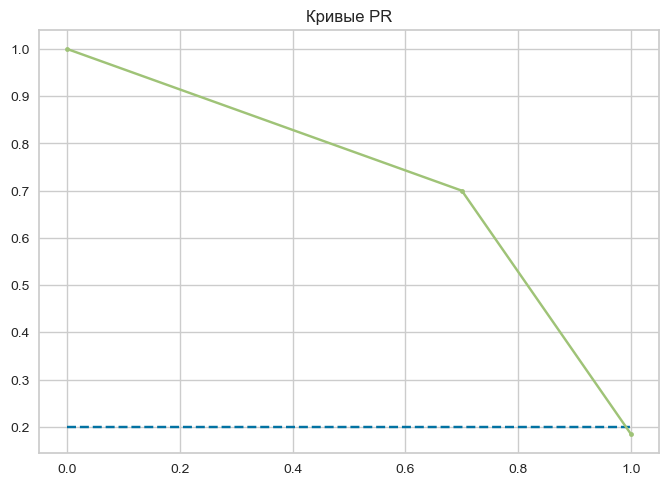

In [70]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_clftree)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [71]:
# площадь под кривыми PR-AUC
pr_dt = sklearn.metrics.auc(recall, precision); pr_dt

0.7276845637583893

#### Случайный лес

In [72]:
%%time
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

CPU times: total: 2.02 s
Wall time: 2.02 s


RandomForestClassifier()

In [73]:
y_pred_rfc = rfc.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rfc)
f1_rf = f1_score(y_test, y_pred_rfc)
prec_rf = precision_score(y_test, y_pred_rfc)
rec_rf = recall_score(y_test, y_pred_rfc)

print(f'Accuracy score: {acc_rf}')
print(f'F1 score: {f1_rf}')
print(f'Precision score: {prec_rf}')
print(f'Recall score: {rec_rf}')

Accuracy score: 0.9345637583892618
F1 score: 0.8142857142857142
Precision score: 0.855
Recall score: 0.7772727272727272


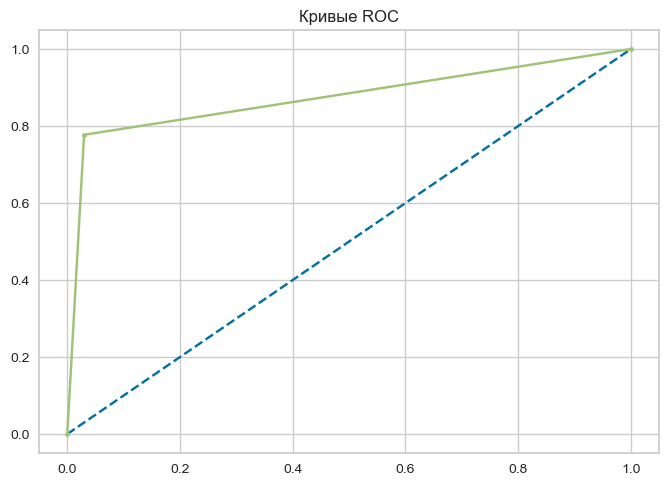

In [74]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_rfc)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [75]:
# площадь под кривыми ROC-AUC
roc_rf = sklearn.metrics.roc_auc_score(y_test, y_pred_rfc); roc_rf

0.8737186681631126

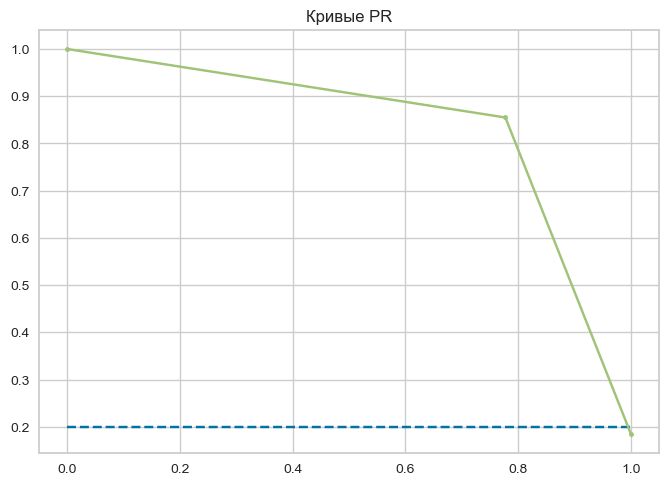

In [76]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_rfc)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [77]:
# площадь под кривыми PR-AUC
pr_rf = sklearn.metrics.auc(recall, precision); pr_rf

0.8366900549115314

#### Многослойный перцептрон

In [91]:
%%time
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

CPU times: total: 2.92 s
Wall time: 1.47 s


MLPClassifier()

In [92]:
y_pred_mlp = mlp.predict(X_test)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp)
rec_mlp = recall_score(y_test, y_pred_mlp)

print(f'Accuracy score: {acc_mlp}')
print(f'F1 score: {f1_mlp}')
print(f'Precision score: {prec_mlp}')
print(f'Recall score: {rec_mlp}')

Accuracy score: 0.7441275167785235
F1 score: 0.4031311154598826
Precision score: 0.3539518900343643
Recall score: 0.4681818181818182


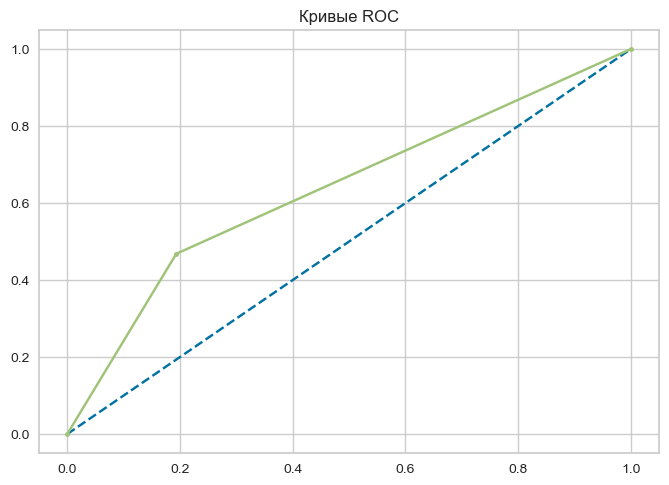

In [93]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_mlp)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [94]:
# площадь под кривыми ROC-AUC
roc_mlp = sklearn.metrics.roc_auc_score(y_test, y_pred_mlp); roc_mlp

0.6373830901608679

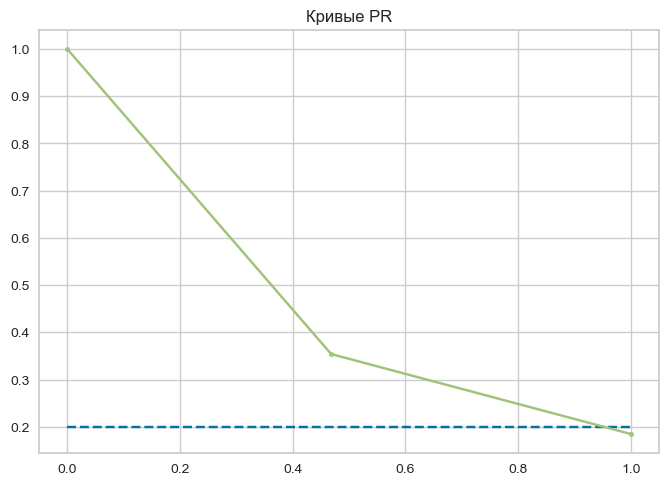

In [95]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_mlp)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [96]:
# площадь под кривыми PR-AUC
pr_mlp = sklearn.metrics.auc(recall, precision); pr_mlp

0.4601440353161449

### Выбрать наиболее перспективную модель для решения поставленной задачи. Изменить гиперпараметры модели. Предпочтительно, провести Grid Search. Найти оптимальные гиперпараметры.

In [126]:
names = ['LogisticRegression','KNN','SVM_linear','SVM_rbf','SVM_poly','SVM_sigmoid','GaussianNB','DecisionTree',\
         'RandomForest','MLP']
column_names = ['Accuracy score','F1 score','Precision score','Recall score','ROC-AUC','PR-AUC']
results = pd.DataFrame(data=[[acc_lr,f1_lr,prec_lr,rec_lr,roc_lr,pr_lr],\
                            [acc_knn,f1_knn,prec_knn,rec_knn,roc_knn,pr_knn],\
                            [acc_lin,f1_lin,prec_lin,rec_lin,roc_lin,pr_lin],\
                            [acc_rbf,f1_rbf,prec_rbf,rec_rbf,roc_rbf,pr_rbf],\
                            [acc_poly,f1_poly,prec_poly,rec_poly,roc_poly,pr_poly],\
                            [acc_sigmoid,f1_sigmoid,prec_sigmoid,rec_sigmoid,roc_sigmoid,pr_sigmoid],\
                            [acc_nb,f1_nb,prec_nb,rec_nb,roc_nb,pr_nb],\
                            [acc_dt,f1_dt,prec_dt,rec_dt,roc_dt,pr_dt],\
                            [acc_rf,f1_rf,prec_rf,rec_rf,roc_rf,pr_rf],\
                            [acc_mlp,f1_mlp,prec_mlp,rec_mlp,roc_mlp,pr_mlp]], index=names, columns=column_names)
results

,Accuracy score,F1 score,Precision score,Recall score,ROC-AUC,PR-AUC
LogisticRegression,0.632550,0.395028,0.283730,0.650000,0.639300,0.499164
KNN,0.738255,0.454545,0.369318,0.590909,0.681257,0.517865
SVM_linear,0.694631,0.420382,0.323529,0.600000,0.658025,0.498677
SVM_rbf,0.727349,0.309979,0.290837,0.331818,0.574345,0.372988
SVM_poly,0.223993,0.314307,0.187777,0.963636,0.510110,0.579062
SVM_sigmoid,0.494128,0.279570,0.189627,0.531818,0.508707,0.403927
GaussianNB,0.769295,0.406048,0.386831,0.427273,0.636990,0.459904
DecisionTree,0.889262,0.700000,0.700000,0.700000,0.816049,0.727685
RandomForest,0.934564,0.814286,0.855000,0.777273,0.873719,0.836690
MLP,0.744128,0.403131,0.353952,0.468182,0.637383,0.460144


Из всех моделей наивысшие показатели метрик Accuracy, F1, Precision, ROC-AUC и PR-AUC показала модель Случайного леса (Random Forest).

Случайный лес обладает следующими гиперпараметрами:
- Количество деревьев (n_estimators);
- Максимальная глубина деревьев (max_depth);
- Минимальное количество объектов в листе (min_samples_leaf);
- Максимальное количество признаков для разбиения (max_features).

Подберем оптимальные параметры с помощью Grid Search:

In [85]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'Оптимальные гиперпараметры: {grid_search.best_params_}')
print(f'Лучший результат кросс-валидации: {grid_search.best_score_}')

Оптимальные гиперпараметры: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150}
Лучший результат кросс-валидации: 0.944992723744846


### С учетом сделанных выводов провести усовершенствование моделей. Это можно осуществить с помощью введения регуляризации, изменение параметров модели (для параметрических моделей), введением суррогатных признаков, отбором признаков, нормализацией данных, ансамблированием моделей, изменением алгоритма предварительной обработки данных. Сравнить результаты.

##### Отбор признаков

Визуализируем важность признаков в модели Случайного леса с оптимальными гиперпараметрами:

DELINQ            0.177288
DEBTINC           0.127198
NINQ              0.103818
DEROG             0.091757
CLAGE             0.082304
VALUE             0.062666
MORTDUE           0.061105
CLNO              0.060983
LOAN              0.059450
YOJ               0.054213
JOB_Office        0.025782
REASON_DebtCon    0.020111
JOB_Other         0.017849
REASON_HomeImp    0.015722
JOB_ProfExe       0.015377
JOB_Mgr           0.011411
REASON_Other      0.007237
JOB_Sales         0.003627
JOB_Self          0.002100
dtype: float64


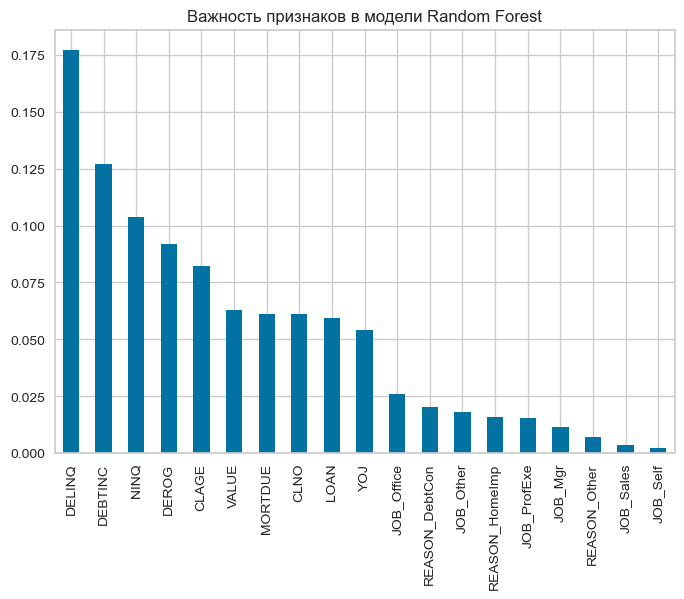

In [86]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=1)
rfc.fit(X_train, y_train)
featimp = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False)
print(featimp)
featimp.plot(kind='bar', title='Важность признаков в модели Random Forest')
print;

Построим корреляционную таблицу:

In [87]:
df.corr()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,REASON_Other,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
BAD,1.000000,-0.075099,-0.046034,-0.028852,-0.058314,0.269921,0.346503,-0.165113,0.168851,-0.004067,0.124324,-0.034210,0.037517,-0.004743,0.032583,-0.073613,0.037949,-0.043561,0.050934,0.046245
LOAN,-0.075099,1.000000,0.216100,0.331862,0.100664,0.006996,-0.028869,0.086874,0.043160,0.071804,0.074823,0.166867,-0.151477,-0.048563,0.018769,-0.018060,-0.058067,0.017488,-0.044993,0.158452
MORTDUE,-0.046034,0.216100,1.000000,0.779787,-0.082856,-0.046476,0.000542,0.130757,0.029480,0.305288,0.128326,0.030416,-0.022894,-0.019581,0.074394,-0.066866,-0.256653,0.256801,0.024822,0.104493
VALUE,-0.028852,0.331862,0.779787,1.000000,0.007382,-0.040727,-0.003615,0.167938,-0.004216,0.264037,0.115796,0.009560,-0.001138,-0.019932,0.045244,-0.058004,-0.264922,0.265850,0.015878,0.150355
YOJ,-0.058314,0.100664,-0.082856,0.007382,1.000000,-0.056245,0.046648,0.190937,-0.067898,0.024023,-0.047642,-0.051937,0.045796,0.018188,0.020148,-0.033088,0.046324,-0.012079,-0.036311,-0.044400
DEROG,0.269921,0.006996,-0.046476,-0.040727,-0.056245,1.000000,0.171286,-0.080144,0.146700,0.050727,0.010744,0.003917,-0.008406,0.009889,0.031342,-0.049223,0.034537,-0.033939,0.030659,0.000836
DELINQ,0.346503,-0.028869,0.000542,-0.003615,0.046648,0.171286,1.000000,0.024874,0.057212,0.159378,0.035353,-0.009383,0.004024,0.012951,0.059350,0.005268,-0.044718,-0.002911,-0.016502,0.021694
CLAGE,-0.165113,0.086874,0.130757,0.167938,0.190937,-0.080144,0.024874,1.000000,-0.110091,0.231595,-0.038052,-0.066849,0.049614,0.044632,-0.023663,-0.001427,-0.076962,0.110431,0.025382,-0.011213
NINQ,0.168851,0.043160,0.029480,-0.004216,-0.067898,0.146700,0.057212,-0.110091,1.000000,0.085148,0.109212,0.121338,-0.115992,-0.022020,0.069826,-0.063735,0.054470,-0.061553,-0.035677,0.016229
CLNO,-0.004067,0.071804,0.305288,0.264037,0.024023,0.050727,0.159378,0.231595,0.085148,1.000000,0.157885,0.116813,-0.107224,-0.031302,0.060210,-0.004549,-0.197815,0.165109,0.049185,0.031325


Выберем признаки, наиболее коррелирующие с целевой переменной (коэф. корреляции по модулю больше 0.05), и заново обучим модель:

In [88]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=1)
rfc.fit(X_train[['LOAN', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'DEBTINC', 'JOB_Office', 'JOB_Sales']], y_train)
y_pred_rfc = rfc.predict(X_test[['LOAN', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'DEBTINC', 'JOB_Office', 'JOB_Sales']])

print(f'Accuracy score: {accuracy_score(y_test, y_pred_rfc)}')

Accuracy score: 0.9085570469798657


Метрика точности снизилась по сравнению с первоначальной моделью.

В данной задаче отбор признаков по коэффициентам корреляции не улучшает качество модели.

### Представить результаты моделирования в наглядном виде (графики, линии обучения, таблицы сравнения моделей, таблицы классификации, и другие). Сделать выводы, сравнить с существующими аналогичными решениями, порассуждать о перспективах решения проблемы.

По результатам сравнения метрик Accuracy score, F1 score, Precision score, Recall score, а также площадей под кривыми ROC и PR, была выбрана модель Случайного леса (Random Forest) с оптимальными гиперпараметрами n_estimators=50, max_depth=20, min_samples_leaf=1, подобранными с помощью Grid Search:

In [98]:
results

,Accuracy score,F1 score,Precision score,Recall score,Area Under ROC-AUC,Area Under PR-AUC
LogisticRegression,0.632550,0.395028,0.283730,0.650000,0.639300,0.499164
KNN,0.738255,0.454545,0.369318,0.590909,0.681257,0.517865
SVM_linear,0.694631,0.420382,0.323529,0.600000,0.658025,0.498677
SVM_rbf,0.727349,0.309979,0.290837,0.331818,0.574345,0.372988
SVM_poly,0.223993,0.314307,0.187777,0.963636,0.510110,0.579062
SVM_sigmoid,0.494128,0.279570,0.189627,0.531818,0.508707,0.403927
GaussianNB,0.769295,0.406048,0.386831,0.427273,0.636990,0.459904
DecisionTree,0.889262,0.700000,0.700000,0.700000,0.816049,0.727685
RandomForest,0.934564,0.814286,0.855000,0.777273,0.873719,0.836690
MLP,0.744128,0.403131,0.353952,0.468182,0.637383,0.460144


Результаты обучения модели с использованием кросс-валидации:

In [112]:
kf = KFold(n_splits=5, shuffle=True)
rfc = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=1)

In [113]:
cv_results = cross_val_score(rfc,
                             X,
                             y,
                             cv = kf,
                             scoring = 'accuracy',
                             n_jobs=-1)

print('Кросс-валидация: ', cv_results)
print('Среднее по кросс-валидации: ', cv_results.mean())
print('Дисперсия по кросс-валидации: ', cv_results.std())

Кросс-валидация:  [0.90016779 0.91694631 0.93540268 0.91526846 0.94043624]
Среднее по кросс-валидации:  0.9216442953020134
Дисперсия по кросс-валидации:  0.014604063857039546


Еще раз выведем на экран графики кривых ROC и PR:

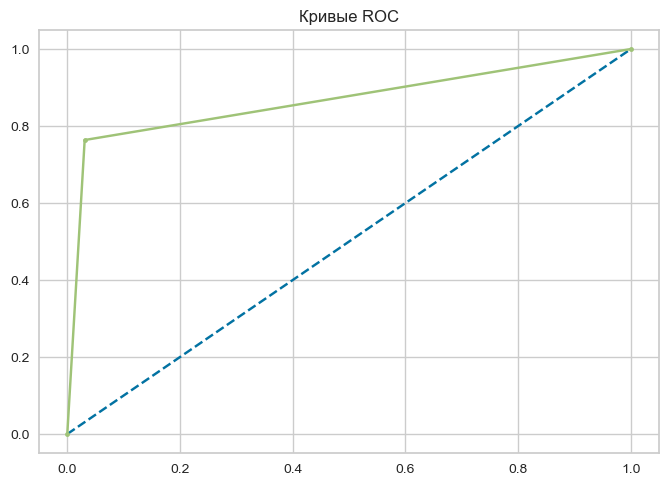

In [101]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_rfc)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

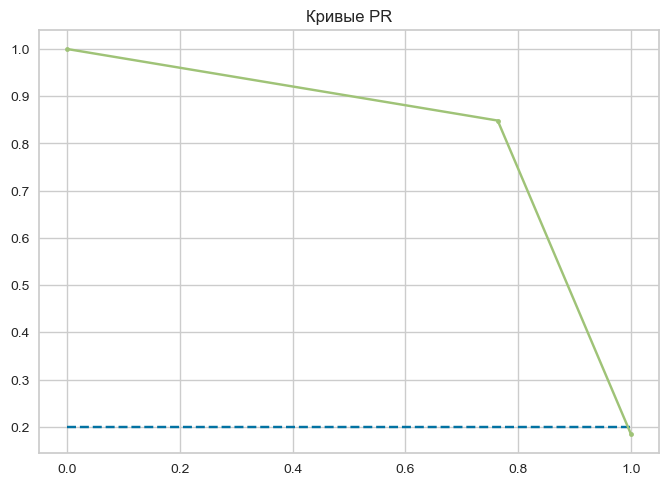

In [102]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_rfc)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

Построим матрицу классификации:

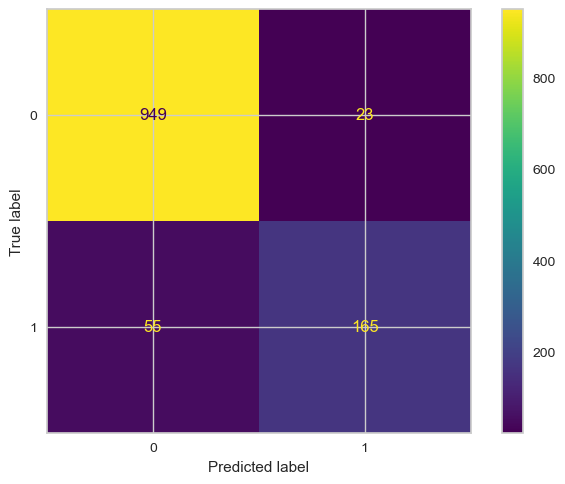

In [123]:
cm = confusion_matrix(y_test, y_pred_rfc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot();

Важность признаков для целевой переменной в данной модели:

DELINQ            0.185782
DEBTINC           0.129130
DEROG             0.086968
CLAGE             0.084884
NINQ              0.080712
LOAN              0.063904
VALUE             0.062451
MORTDUE           0.061231
CLNO              0.058716
YOJ               0.055184
JOB_Office        0.031278
JOB_Other         0.021807
JOB_ProfExe       0.021385
REASON_DebtCon    0.017145
JOB_Mgr           0.012801
REASON_HomeImp    0.012648
REASON_Other      0.006678
JOB_Sales         0.003844
JOB_Self          0.003453
dtype: float64


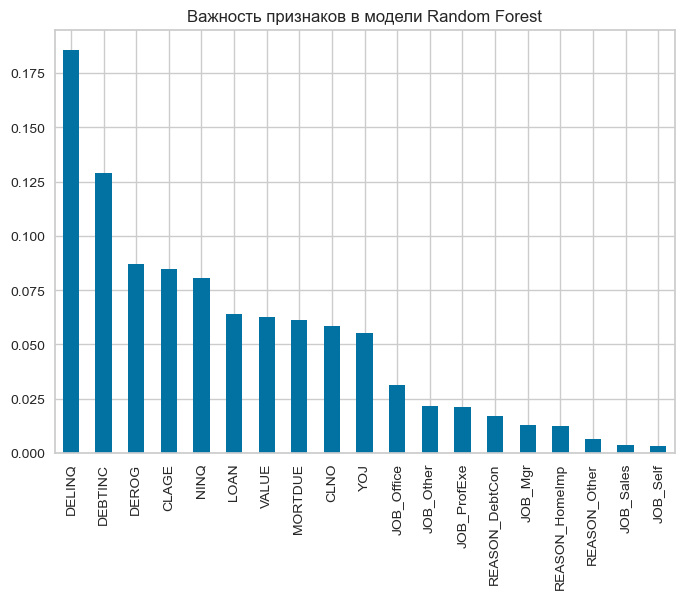

In [119]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=1)
rfc.fit(X_train, y_train)
featimp = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False)
print(featimp)
featimp.plot(kind='bar', title='Важность признаков в модели Random Forest')
print;

В данной работе было показано применение различных моделей машинного обучения в задаче создания алгоритма кредитного скоринга. Кредитование является одной из самых распространенных услуг, предоставляемых банками, а внедрение алгоритмов машинного обучения помогает банковским учреждениям снизить риски. Кроме того, автоматизация процесса выдачи кредита позволяет клиентам получить кредит проще и быстрее.

В процессе работы были задействованы различные алгоритмы машинного обучения, такие как логистическая регрессия, метод K-ближайших соседей, метод опорных векторов, Наивный Байесовский классификатор, дерево решений, случайный лес и многослойный перцептрон. В рамках текущей задачи метрики Accuracy, F1, Precision, ROC-AUC и PR-AUC оказались выше у модели случайного леса Random Forest. Наименее подходящей моделью для данной задачи по показателю метрики Accuracy оказался метод опорных векторов с полиномиальным ядром.

В настоящее время в международном сообществе стоит задача построения единой системы автоматизированного кредитного скоринга, основанной одновременно на нескольких моделях, что будет обеспечивать высокие прогнозные способности этой системы.